# Kimchi Momentum Strategy

In [1]:
%load_ext dotenv
%dotenv

# Fetch and verify Binance data

In [2]:
from binance.um_futures import UMFutures
import os
import json
from datetime import datetime, timezone

START_DATE = datetime(2021, 1,1)
END_DATE = datetime(2023, 1,1)

client = UMFutures(os.getenv("BINANCE_API_KEY"), os.getenv("BINANCE_SECRET_KEY"))

# https://binance-docs.github.io/apidocs/futures/en/#kline-candlestick-data
# https://developers.binance.com/docs/derivatives/usds-margined-futures/market-data/rest-api/Continuous-Contract-Kline-Candlestick-Data
# https://github.com/binance/binance-futures-connector-python/blob/main/binance/um_futures/market.py#L128

def date_to_binance(x):
    return int(datetime.timestamp(x)) * 1000
data = client.continuous_klines("BTCUSDT", "PERPETUAL", "1d", startTime=date_to_binance(START_DATE), endTime=date_to_binance(END_DATE), limit=1000)

print(len(data)) # => 365 * 2
# close time / close price
print(datetime.fromtimestamp(data[0][6] / 1000, timezone.utc).strftime("%c"), data[0][4])
print(datetime.fromtimestamp(data[-1][6] / 1000, timezone.utc).strftime("%c"), data[-1][4])

ds1 = data

730
Fri Jan  1 23:59:59 2021 29337.16
Sat Dec 31 23:59:59 2022 16537.60


# Fetch and verify Upbit data

In [3]:
import requests

def date_to_upbit(x):
    return x.strftime("%Y-%m-%d %H:%M:%S")

to_date = date_to_upbit(END_DATE)
results = []
while(True): 
    url = "https://id-api.upbit.com/v1/candles/days"
    params = {  
        'market': 'IDR-BTC',  
        'count': 200,
        'to': to_date
    }  
    headers = {"accept": "application/json"}
    
    response = requests.get(url, params=params, headers=headers)
    
    data = response.json()
    results += data
    
    to_date = data[-1]["candle_date_time_utc"]

    if "2020-" in to_date:
        break

results.reverse()
results = [x for x in results if "2020-"  not in x["candle_date_time_utc"]]

print(len(results))
print(results[0]["candle_date_time_utc"], results[0]["prev_closing_price"] * 0.00007)
print(results[-1]["candle_date_time_utc"], results[-1]["prev_closing_price"] * 0.00007)

ds2 = results

730
2021-01-01T00:00:00 28536.899999999998
2022-12-31T00:00:00 18109.0


# Transform both datasets into ts/price dfs

In [6]:
import pandas as pd

df1 = pd.DataFrame(ds1)[[4, 5, 6]].rename(columns={4: "price", 5: "Volume", 6: "ts"})
df1["ts"] = pd.to_datetime(df1["ts"] - 1000 * 60 * 60 * 24 + 1,  unit='ms')
df1 = df1.set_index("ts")
df1["price"] = df1["price"].astype(float)
df1

,price,Volume
ts,,
2021-01-01,29337.16,210716.398
2021-01-02,32199.91,545541.080
2021-01-03,33054.53,487486.989
2021-01-04,32031.07,506128.023
2021-01-05,33999.52,433720.833
...,...,...
2022-12-27,16698.20,262828.564
2022-12-28,16539.00,344649.858
2022-12-29,16630.30,208591.531


In [5]:
df2 = pd.DataFrame(ds2)[["candle_date_time_utc", "trade_price"]].rename(columns={"trade_price": "price", "candle_date_time_utc": "ts"})
df2["ts"] = pd.to_datetime(df2["ts"])
df2 = df2.set_index("ts")
df2["price"] = df2["price"] * 0.00007 # IDR TO USDT simplified estimation
df2

,price
ts,
2021-01-01,28808.5
2021-01-02,31314.5
2021-01-03,32381.3
2021-01-04,31587.5
2021-01-05,33280.1
...,...
2022-12-27,18264.4
2022-12-28,18398.8
2022-12-29,18325.3


# Take a look at price diff between exchanges

<Axes: xlabel='ts'>

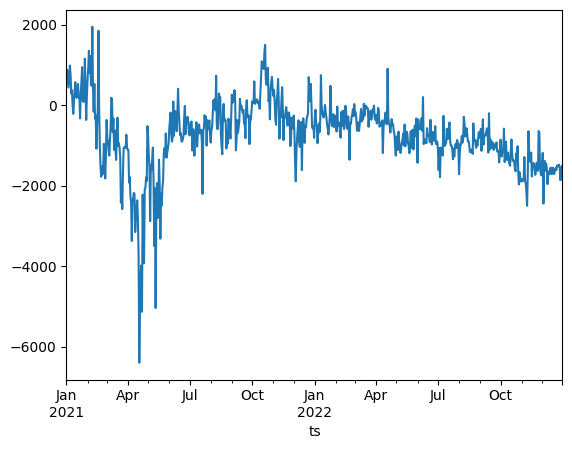

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

df = df1.join(df2, lsuffix='_binance', rsuffix='_upbit')
x = df["price_binance"] - df["price_upbit"]
x.plot()

# Calculate daily momentum

price_upbit_pct_change
False    725
True       5
Name: count, dtype: int64 price_upbit_pct_change
False    724
True       6
Name: count, dtype: int64


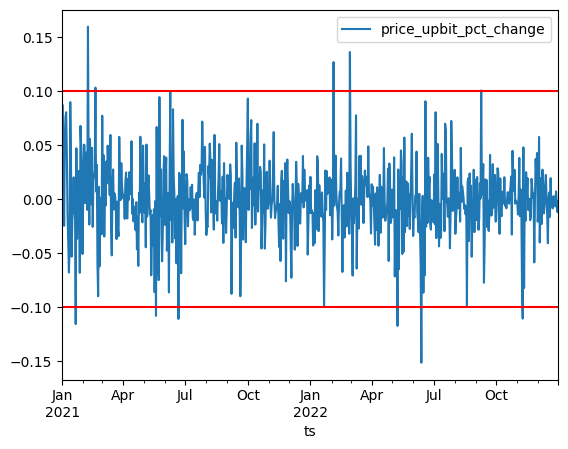

In [8]:
# Assuming that momentum X% and Y% is a daily pct change
df["price_upbit_pct_change"] = df["price_upbit"].pct_change(periods=1)
print((df["price_upbit_pct_change"] > 0.10).value_counts(), (df["price_upbit_pct_change"] < -0.10).value_counts())

df[["price_upbit_pct_change"]].plot()
plt.axhline(y=0.1, color='r', linestyle='-')
plt.axhline(y=-0.1, color='r', linestyle='-')


# Adjust data columns for backtesting api

In [9]:
df= df.rename(columns={"price_binance": "Close"})
df["Open"] = df["High"] = df["Low"] = df["Close"]
df.head()

,Close,Volume,price_upbit,price_upbit_pct_change,Open,High,Low
ts,,,,,,,
2021-01-01,29337.16,210716.398,28808.5,NaN,29337.16,29337.16,29337.16
2021-01-02,32199.91,545541.080,31314.5,0.086988,32199.91,32199.91,32199.91
2021-01-03,33054.53,487486.989,32381.3,0.034067,33054.53,33054.53,33054.53
2021-01-04,32031.07,506128.023,31587.5,-0.024514,32031.07,32031.07,32031.07
2021-01-05,33999.52,433720.833,33280.1,0.053584,33999.52,33999.52,33999.52


# Split data

In [11]:
import numpy as np

train_df, test_df = np.split(df, [365], axis=0)
train_df.index[0], test_df.index[0]

(Timestamp('2021-01-01 00:00:00'), Timestamp('2022-01-01 00:00:00'))

# Implement stategy and test run

In [13]:
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy

from backtesting.test import SMA, GOOG

class KimchiStrat(SignalStrategy):
    x = 100
    y = 100

    def init(self):
        super().init()
        
        signalX = (pd.Series(self.data["price_upbit_pct_change"]) >= (self.x / 1000)).astype(int).diff().fillna(0)
        signalY = (pd.Series(self.data["price_upbit_pct_change"]) <= (-self.y / 1000)).astype(int).diff().fillna(0)
        signalX = signalX.replace(-1, 0)
        signalY = signalY.replace(-1, 0) * -1

        signal = signalX.add(signalY, fill_value=0)
        
        self.set_signal(entry_size=signal)


bt = Backtest(train_df, KimchiStrat, cash=100000, exclusive_orders=True)

import warnings
warnings.filterwarnings('ignore')

output = bt.run(x=61, y=51) # 6.1% 5.1%
bt.plot()

GridPlot(id='p2771', ...)

# Optimize and heatmap

In [14]:
%%time
# range_params = range(1, 150, 1) ## Too heavy
range_params = range(10, 120, 10)
stats, heatmap = bt.optimize(
    x=range_params,
    y=range_params,
    maximize='Equity Final [$]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

heatmap.sort_values().iloc[-3:]

CPU times: user 106 ms, sys: 240 ms, total: 346 ms
Wall time: 1.3 s


x   y 
70  50    132244.00
    40    132254.12
60  70    135899.12
Name: Equity Final [$], dtype: float64

In [15]:
from backtesting.lib import plot_heatmaps

plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p3486', ...)

# Optimize using decision trees

In [16]:
%%time
stats_skopt, heatmap, optimize_result = bt.optimize(
    x=[1, 150],
    y=[1, 150],
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

heatmap.sort_values().iloc[-3:]

CPU times: user 42.8 s, sys: 1.93 s, total: 44.7 s
Wall time: 42.7 s


x   y 
67  51    157133.5
63  51    157133.5
61  51    157133.5
Name: Equity Final [$], dtype: float64

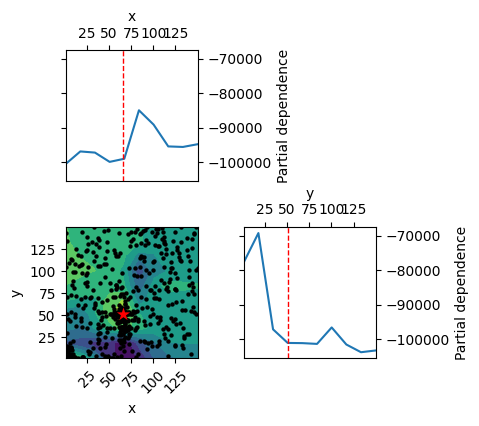

In [17]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

# Run forward testing

In [18]:
res_x, res_y = heatmap.sort_values().iloc[-1:].index.to_list()[0]

output = bt.run(x=res_x, y=res_y)
bt.plot()

GridPlot(id='p4139', ...)

# Results

In [19]:
print(f"X: {res_x/10}%, Y: -{res_y/10}%")
for i in ["Sharpe Ratio", "Max. Drawdown [%]", "Return (Ann.) [%]"]: 
# Return (Ann.) [%]  doesn't make much sense for 1+1 years data
# So no reinvesting opportunity here
    print(f"{i} {output[i]}") 

X: 6.1%, Y: -5.1%
Sharpe Ratio 1.1693942789379315
Max. Drawdown [%] -15.31129994163436
Return (Ann.) [%] 57.1335000000021
